<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/main/Spectral_Clustering/01_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1:  Coupled Spring System Simulation

## The Setup
Consider we have system with $3$ particles and they are connected with springs pariwisely. The spring that connects particle $i$ and $j$ has spring constant $k_{ij}$. Specifically, the spring that connects particle $1$ and $2$ has spring constant $k_{12}$ and the spring that connects particle $2$ and $3$ has spring constant $k_{23}$ and there is a spring that connects particle $1$ and $3$ which has spring constant $k_{13}$. Also, notice $k_{12} = k_{21}$ since the spring that connects particle $1$ and $2$ is the same as the one connecting $2$ and $1$. For any $i,j$, we have $k_{ij} = k_{ji}$. The setup is shown below.

As a physicist, we would like to study the motion of the sytem for a given initial condition. To simplify the notation, we will use $x_i$ to denote the displacement of particle $i$ from its equilibrium position.
The coordinate definition is shown below:
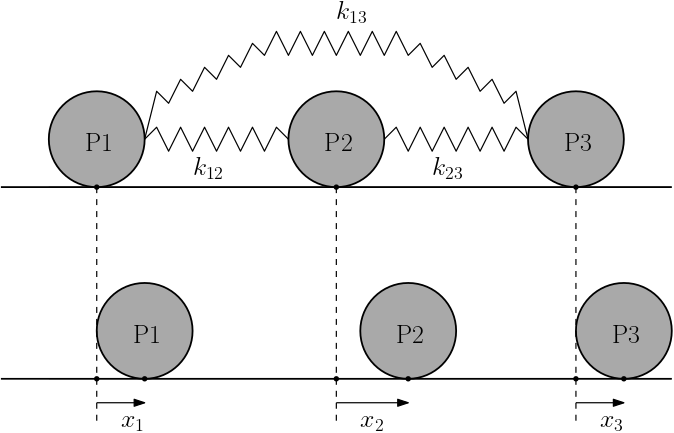

## Equation of Motion

In order to study the motion of the system, we first need to setup the equation of motion from the Newton's second law. For particle $1$, we have the force from spring $k_{12}$ and spring $k_{13}$ and thus, we have 

$$
m\frac{d^2 x_1}{dt^2} = k_{12}(x_2-x_1) + k_{13}(x_3-x_1)
$$

For particle $2$, we have spring $k_{21}$ with displacement $x_2-x_1$ pulling to the left and $k_{23}$ with displacement $x_3- x_2$ pulling to the right and thus 

$$
m\frac{d^2 x_2}{dt^2} = -k_{21}(x_2-x_1) + k_{23}(x_3-x_2)
$$

For particle $3$, the spring $k_{31}$ and $k_{32}$ with displacements $(x_3-x_1)$ and $(x_3-x_2)$ respectively to the left and thus

$$
m\frac{d^2 x_3}{dt^2} = -k_{31}(x_3-x_1) - k_{32}(x_3-x_2)
$$

We can rearrange the right hand side of the equations and put them together to get 

$$
\begin{aligned}
&m\frac{d^2 x_1}{dt^2} = - (k_{12} + k_{13})x_1 + k_{12} x_2 + k_{13} x_3 \\
&m\frac{d^2 x_2}{dt^2} = - (k_{21} + k_{23})x_2 + k_{21} x_1 + k_{23} x_3 \\
&m\frac{d^2 x_3}{dt^2} = - (k_{31} + k_{32})x_3 + k_{31} x_1 + k_{32} x_2\\
\end{aligned}
$$



## Integrate the Equation of Motion

We could solve the equation of motion analytically but to focus on the results, we skip this part and try to solve it numerically. Here we use the `scipy.integrate.solve_ivp` to perform Runge-Kutta integration which is a numerical integration method that has the fourth order error scaling. This numerical method simulates the force and displacements $x$ step by step with time stepsize $\Delta t$. 
The method can guarantee that $x'(t)$ and the true $x(t)$ have error $|x'(t)-x(t)|\sim (\Delta t)^4$. 

In order to use this RK5 integration method, we should rewrite our equation of motion in terms of displacements $x_i$ and $v_i$ where $v_i = \dot{x}_i$. The equation then becomes trivially as 

$$
\begin{aligned}
&\frac{dx_1}{dt} = v_1 dt\\
&\frac{dx_2}{dt} = v_2 dt\\
&\frac{dx_3}{dt} = v_3 dt\\
&m\frac{d v_1}{dt} = - (k_{12} + k_{13})x_1 + k_{12} x_2 + k_{13} x_3 \\
&m\frac{d v_2}{dt} = - (k_{21} + k_{23})x_2 + k_{21} x_1 + k_{23} x_3 \\
&m\frac{d v_3}{dt} = - (k_{31} + k_{32})x_3 + k_{31} x_1 + k_{32} x_2\\
\end{aligned}
$$

The second step is to tell the computer this equation. In order to do that, we should tell the computer what the parameters $k_{ij}$ are. The $k_{ij}$ will be kept in an `numpy.array` with the $(i,j)$ term as $k_{ij}$. Let's assume we already have this parameter and we are ready to write above equations into code!

The functions we want to get from the numerical integrator is $x_1(t), x_2(t), x_3(t), v_1(t), v_2(t), v_3(t)$. We can keep them into an `numpy.array` called `xv` and we should prodce the derivative for them. First the derivative for $x_t$ should be given as the function `dx_dt`.

In [1]:
def dx_dt(t, xv):
    return xv[3:]

Here the function takes an argument of time $t$ is because the derivative in general could depend on $t$ and thus this is required in `scipy.integrate.solve_ivp`. However, in our problem we do not need `t` and thus it only passed in but does not play a role in the computation. 

The equation derivative of $v_i$ not only depends $x_t$ but also on $k_{ij}$, we thus need a function that gives us a function `dv_dt` which already taken the information from $k$.

In [2]:
def produce_dv_dt(k):
    def dv_dt(t, xv):
        x1, x2, x3 = xv[0], xv[1], xv[2]
        
        dv1 = - (k[0,1]+ k[0,2])*x1 + k[0,1] *x2 + k[0,2]*x3
        dv2 = - (k[1,0]+ k[1,2])*x2 + k[1,0] *x1 + k[1,2]*x3
        dv3 = - (k[2,0]+ k[2,1])*x3 + k[2,0] *x1 + k[2,1]*x2
        
        return np.array([dv1, dv2, dv3])
    return dv_dt

We then could produce the integrate function which takes initial condition and the parameters $k_{ij}$. 

In [3]:
import numpy as np
import scipy.integrate 
import matplotlib.pyplot as plt

def integrate(xv_initial, ti, tf, steps, k):
    dv_dt = produce_dv_dt(k)
    def dxv_dt(t, xv):
        dxdt = dx_dt(t, xv)
        dvdt = dv_dt(t, xv)
        return np.concatenate([dxdt, dvdt])
    t_eval = np.linspace(ti,tf,steps)
    sol = scipy.integrate.solve_ivp(dxv_dt, (ti, tf), xv_initial, t_eval = t_eval)
    t = sol.t
    xv = sol.y
    return t, xv[:3,:], xv[3:,:] 

We could then perform the calculation for 10 seconds with initial condition that $v = 0$, $x_1 =1.0, x_2 = 0.5$ and $x_3 = -1$. The spring setup is $k_{12} = 10$ while $k_{13} = 1$ and $k_{23} = 1$. 

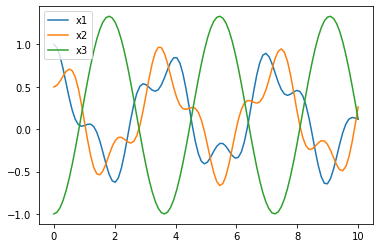

In [4]:
def plot_X(T,X):
    plt.plot(T, X[0,:], label = "x1")
    plt.plot(T, X[1,:], label = "x2")
    plt.plot(T, X[2,:], label = "x3")
    plt.legend()
    plt.show()

xv_initial_1 = np.array([1, 0.5, -1, 0, 0, 0])
ti, tf = 0.0, 10.0
steps = 100
k1 = np.zeros((3,3))
k1[0,1] = k1[1,0] = 10 # k12
k1[1,2] = k1[2,1] = 1 # k23
k1[0,2] = k1[2,0] = 1 # k13


T, X, V = integrate(xv_initial_1, ti, tf, steps, k1 )

plot_X(T,X)

From the plot we could see that the particle $1$ and particle $2$ has same oscillation frequency and similar magnitude. We thus naturally will infer that **particles with stronger pairwise coupling constant (the spring constant) tend to oscillate together**. We could verify our guess by changing the spring constant $k_{13}$ to $10$ and $k_{12}$, $k_{23}$ to $1$. Thus, we would expect the particle $1$ and particle $3$ to oscillate together.

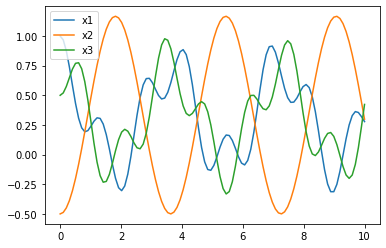

In [5]:
xv_initial_2 = np.array([1, -0.5, 0.5, 0, 0, 0])
ti, tf = 0.0, 10.0
steps = 100
k2 = np.zeros((3,3))
k2[0,1] = k2[1,0] = 1  # k12
k2[1,2] = k2[2,1] = 1  # k23
k2[0,2] = k2[2,0] = 10 # k13


T, X, V = integrate(xv_initial_2, ti, tf, steps, k2 )

plot_X(T,X)

From the above plot, we could see that indeed, particle $1$ and particle $3$ oscillate in the similar phase and the distance between them is shorter than that between each of them with particle $2$. 

Note that we changed the initial coordinates of the particles. This is because we want to keep the system to have similar energies and do not want to just permute the labeling equivalently. We want to have similar energies because high energies could break the bonding between strong bonding pairs. We could verify that the two systems have similar energy by the following function:

In [6]:
def get_E(xv_initial, k):
    x1, x2, x3 = xv_initial[:3]
    v1, v2, v3 = xv_initial[3:]
    potentials = 0.5*k[0,1]*(x1-x2)**2 + 0.5*k[1,2]*(x3-x2)**2 + 0.5*k[0,2]*(x3-x1)**2
    kinetics = 0.5*v1**2 + 0.5*v2**2+0.5*v3**2
    
    return potentials + kinetics

print ("system 1 energy: %.3f" %(get_E(xv_initial_1, k1)) )
print ("system 2 energy: %.3f" %(get_E(xv_initial_2, k2)))

system 1 energy: 4.375
system 2 energy: 2.875



From the above two examples, we could see that if spring constant is strong between two particles, they tend to oscillate together. If the partciles are not physical particles but abstract data points and the spring constant $k_{ij}$ describes the similarity measure between data points, we could use the oscillating coordinates to group the data points. This is because, if two data points have large similarity measure (strong spring constants), they tend to oscillate together. As a result, the "oscillating" coordinates of the data points tend to help us to do clustering on the data pionts.

In next part, we will precisely solve the oscillating system and see how we could use "normal modes" to cluster the "particles". 

## Quizs

### Quiz 1

In the second example, we set up $k_{12} = 1$, $k_{13} = 10$ and $k_{23} = 1$ and we set the initial condition as
$ x_1 = 1$, $x_2 = -0.5$ and $x_3= 0.5$. What if we set $x_1 =1$, $x_2 = -1$, $x_3= 0.5$? What do you expect to happen?



### Solution:

This is equivalent to the first setup since it is a permutation of labeling as $2\rightarrow 3$ and $3\rightarrow 2$. 

## Homework

### Problem 1

We could define the coordinates of the particle system into a vector. For example, in the three body system, $\mathbf{x} = (x_1,x_2,x_3)$.

Now given the equations of motion of the three particle system:

$$
\begin{aligned}
&m\frac{d^2 x_1}{dt^2} = - (k_{12} + k_{13})x_1 + k_{12} x_2 + k_{13} x_3 \\
&m\frac{d^2 x_2}{dt^2} = - (k_{21} + k_{23})x_2 + k_{21} x_1 + k_{23} x_3 \\
&m\frac{d^2 x_3}{dt^2} = - (k_{31} + k_{32})x_3 + k_{31} x_1 + k_{32} x_2\\
\end{aligned}
$$

Can you write down the equation in matrix form?

### Problem 2

Could you give initial conditions with higher energies in the `k2` system and simulate? Do you still observe that pairs with strong bonding have similar coordinates? What about oscillation frequencies?


### Solution:

The high energy initial condition will break the bonds between strong bonding particles. However the pairs with strong bonding will oscillate in similar frequencies. 

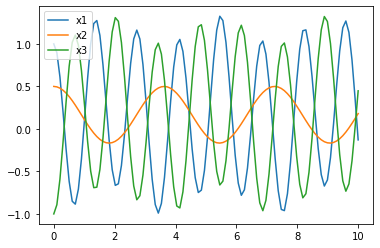

system 2 energy: 21.250


In [7]:
xv_initial = np.array([1, 0.5, -1, 0, 0, 0])
ti, tf = 0.0, 10.0
steps = 100

T, X, V = integrate(xv_initial, ti, tf, steps, k2 )

plot_X(T,X)
print ("system 2 energy: %.3f" %(get_E(xv_initial, k2)))